In [1]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import *
import matplotlib.pyplot as plt
#from radiomics.featureextractor import *
from sklearn import mixture

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
#from library_dicom.post_processing.GaussianModel import GaussianModel
from library_dicom.post_processing.WatershedModel import WatershedModel 
from library_dicom.dicom_processor.tools.folders import *
from library_dicom.dicom_processor.tools.threshold_mask import *

In [2]:
#First Example with 4D mask , threshold = 3

In [2]:
import SimpleITK as sitk  
#mask_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
#pet_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

mask_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101061005/pet0/1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
pet_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/GAINED_NIFTI/11011101061005/pet0/1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

In [4]:
model = WatershedModel(mask_path, pet_path, type = '4d')

In [5]:
ws_array, label_number = model.watershed_model(3)

In [6]:
label_number 

21

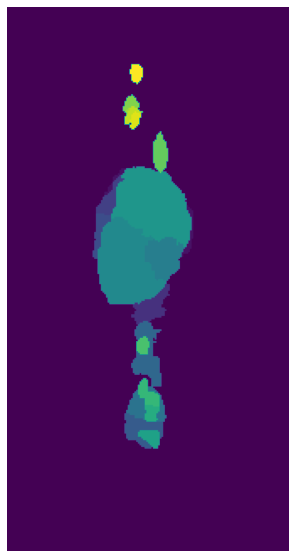

In [7]:
mip_imshow(ws_array, 0, cmap='viridis', type = 'mask', vmin = None, vmax = None)

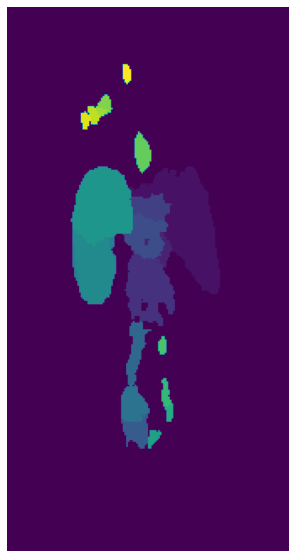

In [8]:
mip_imshow(ws_array, 90, cmap='viridis', type = 'mask', vmin=None, vmax=None)

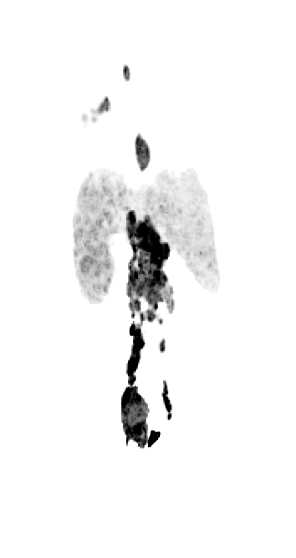

In [9]:
suv_values = model.get_pet_view(model.pet_array, ws_array)
mip_imshow(suv_values, 90, cmap='Greys', type = 'pet', vmin = 3, vmax = 22 )

In [10]:
study_uid ='test'
path_image = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl'

mip_projection(suv_values, 90, path_image, study_uid, type='pet', cmap='Greys', vmin = 3, vmax = 22)

'/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl/test_mip_pet_90.png'

for i in range(1, label_number + 1):
    new_mask = np.zeros((model.size_matrix))
    x,y,z = np.where(ws_array == i)

    for j in range(len(x)):
        new_mask[x[j], y[j], z[j]] = i

    mip_imshow(new_mask, 90, cmap='viridis', type='mask')

In [ ]:
#Other example : AHL prédictions mask, thresold = 0.5

In [2]:
import csv
import SimpleITK as sitk

In [3]:
csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_ecart_volume.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data = []
    for row in reader :
        csv_data.append(row)
        
del csv_data[0] #enlever première ligne

In [4]:
csv_data[244]

['13011102161003',
 '2.16.840.1.113669.632.20.689996.10000290988',
 '/media/deeplearning/Elements/AHL2011_NIFTI/2.16.840.1.113669.632.20.689996.10000290988_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/2.16.840.1.113669.632.20.689996.10000290988_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/ran_he_dec 5_2011.csv',
 '2235.41',
 '2284.4199999999996',
 '49.00999999999976']

In [5]:
len(csv_data)

404

In [6]:
results_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/results_ahl'
error = []
path_mip = []

tmtv = []
tmtv_binary = []

for serie in csv_data : 
    print(csv_data.index(serie))
    subliste = []
    try : 
        model = WatershedModel(serie[3], serie[2], type = '3d')
        ws_array, label_number = model.watershed_model(0.5)

        folder = results_directory+'/'+serie[1]
        if not os.path.exists(folder):
            os.makedirs(folder) 


        angle_filename_mask = mip_projection(ws_array, 90, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        print("MIP MASK 90")
        subliste.append(angle_filename_mask)
        suv_values_array = model.get_pet_view(model.pet_array, ws_array)
        angle_filename_pet = mip_projection(suv_values_array, 90, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 10 )
        subliste.append(angle_filename_pet)
        print("MIP PET 90")
        subliste.append(serie[1])
        subliste.append(label_number)
        path_mip.append(subliste)

        other_angle = []
        angle_filename_mask_0 = mip_projection(ws_array, 0, folder, serie[1], type ='mask', cmap='viridis', vmin = None, vmax = None)
        other_angle.append(angle_filename_mask_0)
        print("MIP MASK 0")
        angle_filename_pet_0 = mip_projection(suv_values_array, 0, folder, serie[1], type='pet', cmap='Greys', vmin = 3, vmax = 10 )

        other_angle.append(angle_filename_pet_0)
        print("MIP PET 0")
        other_angle.append(serie[1])
        other_angle.append(label_number)
        path_mip.append(other_angle)

        ws_array = get_threshold_matrix(ws_array, model.pet_array, label_number, 0.41)
        img = sitk.GetImageFromArray(ws_array)
        img2 = sitk.GetImageFromArray(ws_array.transpose())
        img.SetDirection(model.pet_direction)
        img.SetOrigin(model.pet_origin)
        img.SetSpacing(model.pet_spacing)
        img2.SetDirection(model.pet_direction)
        img2.SetOrigin(model.pet_origin)
        img2.SetSpacing(model.pet_spacing)
        filename = folder+'/'+serie[1]+'_nifti_mask.nii'
        sitk.WriteImage(img, filename)

        json_details = model.label_stat_results(img2)
        tmtv.append(json_details['total_vol'])
        write_json_file(folder, serie[1]+'_details', json_details)


        #tmtv binary 

        binary_array = model.get_binary_threshold_mask_array(0.5)


        binary_array = get_threshold_matrix(binary_array, model.pet_array, 1, 0.41)

        pixel_volume = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2] * 10**(-3) 
        number_pixel = len(np.where(binary_array != 0)[0])
    
        tmtv_binary.append(pixel_volume * number_pixel)


    except Exception as err : 
        print(err)
        print(serie)
        error.append(serie)

0
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
1
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
2
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
3
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
4
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
5
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
6
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
7
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
8
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
9
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
10
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
11
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
12
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
13
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
14
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
15
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
16
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
17
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
18
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
19
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
20
MIP MASK 90
MIP PET 90
MIP MASK 0
MIP PET 0
21
MIP MASK 90
MIP PET 

In [43]:
#calcul tmtv binaire 41%

tmtv_binary = []
for serie in csv_data : 
    print(csv_data.index(serie))
    #subliste = []
    try : 
        model = WatershedModel(serie[3], serie[2], type = '3d')
        ws_array, label_number = model.watershed_model(0.5)

        binary_array = model.get_binary_threshold_mask_array(0.5)


        binary_array = get_threshold_matrix(binary_array, model.pet_array, 1, 0.41)

        pixel_volume = model.pet_spacing[0]*model.pet_spacing[1]*model.pet_spacing[2] * 10**(-3) 
        number_pixel = len(np.where(binary_array != 0)[0])
    
        tmtv_binary.append(pixel_volume * number_pixel)


    except Exception as err : 
        print(err)
        print(serie)
        error.append(serie)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
len(tmtv_binary)

404

In [8]:
len(tmtv)

404

In [9]:
filename = os.path.join(results_directory, 'list_mip_min_dist_2cm_6connex_all_dataset.pdf')
create_pdf_mip(path_mip, filename) 

In [10]:
csv_post = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_ecart_volume.csv'

with open(csv_post, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_2 = []
    for row in reader :
        csv_data_2.append(row)
        
del csv_data_2[0] #enlever première ligne


In [11]:
print(len(csv_data_2))

404


In [12]:
volume_total_csv = []
for row in csv_data_2 : 
    volume_total_csv.append(row[5])


In [13]:
print(len(volume_total_csv))

404


In [14]:
#diff cs manual et auto
diff = []
pourcent = []
index = []
for i in range(len(tmtv)):
    print(i)

    diff.append(tmtv[i] - float(volume_total_csv[i]))
    result = abs(tmtv[i] - float(volume_total_csv[i]))
    pourcent.append((result / float(volume_total_csv[i])) * 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
len(diff)

404

In [16]:
len(pourcent)

404

In [17]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_post_process_tmtv_mindist_2cm_all_dataset.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "CSV", "VOL_TOTAL", "SUM_ROI_VOLUME", "DIFF", "WS_VOL", "DIFF_WS_CSV", "POURCENT", "TMTV_BINARY"])
    for serie in csv_data_2: 
        if csv_data_2.index(serie) != 244 : 
            index = csv_data_2.index(serie)
            csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], tmtv[index], diff[index], pourcent[index], tmtv_binary[index]])

In [18]:
#count 

csv_ahl_post_process= '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing/ahl_post_process_tmtv_mindist_2cm_all_dataset.csv'

with open(csv_ahl_post_process, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    csv_data_3 = []
    for row in reader :
        csv_data_3.append(row)
        
del csv_data_3[0] #enlever première ligne

In [19]:
pourcent = []
for row in csv_data_3:
    pourcent.append(row[-2])


In [25]:
cpt = 0
for item in pourcent : 
    if float(item) < float(15) : 
        cpt += 1


cpt 

99

In [22]:
vol_total_csv = []
vol_binary = []
vol_sous_seg = []
diff = []
for row in csv_data_3 :
    vol_total_csv.append(float(row[5]))
    vol_binary.append(float(row[-1]))
    vol_sous_seg.append(float(row[8]))
    diff.append(float(row[9]))

slope : 0.28103244094569096
intercept : 7.539189168377931
coeff de correlation : 0.5631745866253409
p value : 4.2403154515861446e-35
stderr : 0.020592018109281966


Text(0.5, 1.0, 'Linear regression')

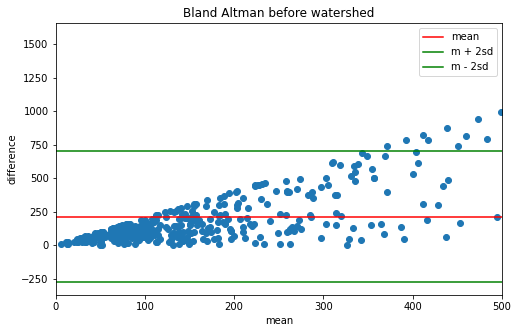

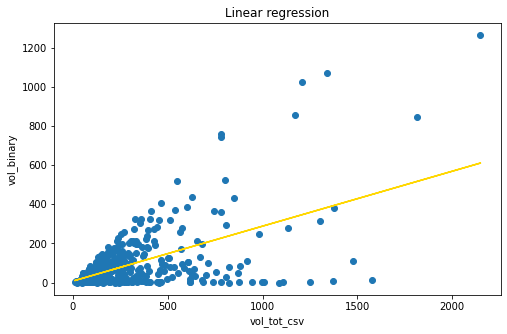

In [32]:
#binary mask Bland Altman 

difference = []
mean = []
for i in range(len(vol_total_csv)):
    difference.append((vol_total_csv[i] - vol_binary[i]))
    subliste = []
    subliste.append(vol_total_csv[i])
    subliste.append(vol_binary[i])
    mean.append(np.mean(subliste))


#plt.hist(difference,bins='fd')


f = plt.figure(figsize=(8,5))
axes = plt.gca()
moy = np.mean(difference)
sd = np.std(difference)
plt.axhline(moy, c='r', label='mean')
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.scatter(mean, difference)
plt.xlim(0, 500)
plt.xlabel('mean')
plt.ylabel('difference')
plt.legend()
plt.title('Bland Altman before watershed')

from scipy import stats
slope, intercept, r_value , p_value , stderr = stats.linregress(vol_total_csv, vol_binary)

print("slope :", slope)
print("intercept :", intercept)
print("coeff de correlation :", r_value)
print("p value :", p_value)
print("stderr :", stderr)

def regression(x, slope, intercept):
    y=[]
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_binary)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='gold', label = 'linear regression')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_binary')
plt.title("Linear regression")

slope : 0.5764402740163912
intercept : 35.969185695173195
coeff de correlation : 0.727439290843022
p value : 1.4027766724533946e-67
stderr : 0.027153036095250067


Text(0.5, 1.0, 'Linear regression')

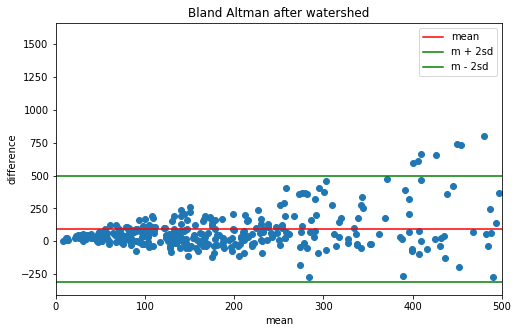

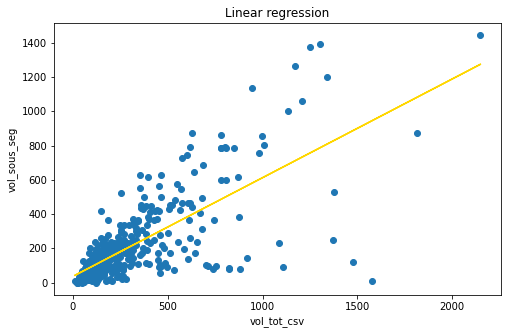

In [33]:
difference = []
mean = []
for i in range(len(vol_total_csv)):
    difference.append(vol_total_csv[i] - vol_sous_seg[i])
    subliste = []
    subliste.append(vol_total_csv[i])
    subliste.append(vol_sous_seg[i])
    mean.append(np.mean(subliste))


#plt.hist(difference, bins = 'fd')


f = plt.figure(figsize=(8,5))
axes = plt.gca()
moy = np.mean(difference)
sd = np.std(difference)
plt.axhline(moy, c='r', label='mean')
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.scatter(mean, difference)
plt.xlim(0, 500)
plt.xlabel('mean')
plt.ylabel('difference')
plt.legend()
plt.title('Bland Altman after watershed')

from scipy import stats
slope, intercept, r_value , p_value , stderr = stats.linregress(vol_total_csv, vol_sous_seg)
print("slope :", slope)
print("intercept :", intercept)
print("coeff de correlation :", r_value)
print("p value :", p_value)
print("stderr :", stderr)

def regression(x, slope, intercept):
    y=[]
    for i in range(len(x)):
        y.append(slope * x[i] + intercept)

    return y 

f = plt.figure(figsize=(8,5))
axes = plt.gca()
plt.scatter(vol_total_csv, vol_sous_seg)
plt.plot(vol_total_csv, regression(vol_total_csv, slope, intercept), c='gold', label='linear regression')
plt.xlabel('vol_tot_csv')
plt.ylabel('vol_sous_seg')
plt.title('Linear regression')

In [7]:
#check

serie = csv_data[1]

In [8]:
serie

['13011101061004',
 '1.3.12.2.1107.5.1.4.45527.30000011092712564387500000019',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.3.12.2.1107.5.1.4.45527.30000011092712564387500000019_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.3.12.2.1107.5.1.4.45527.30000011092712564387500000019_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/hen_he_sep 27_2011.csv',
 '740.63',
 '808.99',
 '68.36000000000001']

In [9]:
truth =  '/media/deeplearning/Elements/AHL2011_NIFTI/1.3.12.2.1107.5.1.4.45527.30000011092712564387500000019_nifti_mask.nii'
pet_path = serie[2]
predi = serie[3]


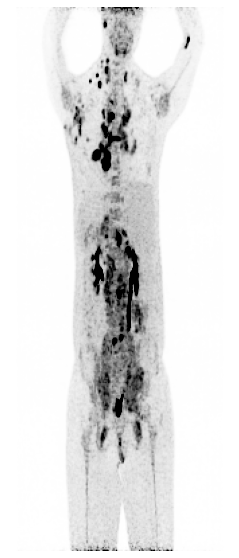

In [10]:
#pet_array
pet_img = sitk.ReadImage(pet_path)
pet_array = sitk.GetArrayFromImage(pet_img).transpose()
mip_imshow(pet_array, 90, cmap='Greys', type='pet', vmin=0, vmax = 5)

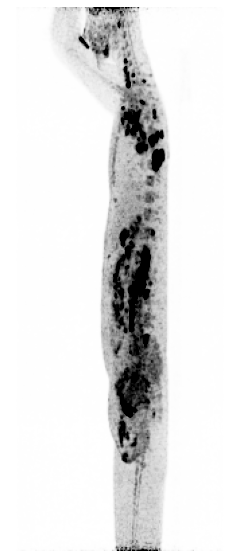

In [31]:
mip_imshow(pet_array, 0, cmap='Greys', type='pet', vmin=0, vmax = 4)

In [16]:
#vérité de terrain non seuillée
img = sitk.ReadImage(truth)
array = sitk.GetArrayFromImage(img).transpose()

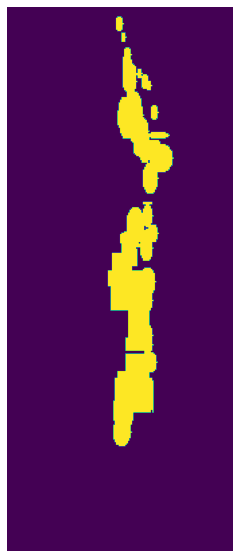

In [17]:
array.shape
mip_imshow_4D(array, 90, cmap='viridis')

In [18]:
array.shape

(168, 168, 405, 84)

In [21]:
#verité de terrain seuillée à 0.41%
for i in range(84) : 
    points = []
    suv_values = []
    x,y,z = np.where(array[:,:,:,i] == 1)
    for j in range(len(x)): 
        points.append([x[j], y[j], z[j]])

    for point in points : 
        suv_values.append(pet_array[point[0], point[1], point[2]])

    seuil = np.max(suv_values) * 0.41 

    for point in points : 
        if pet_array[point[0], point[1], point[2]] <= seuil : 
            array[point[0], point[1], point[2], i ] = 0

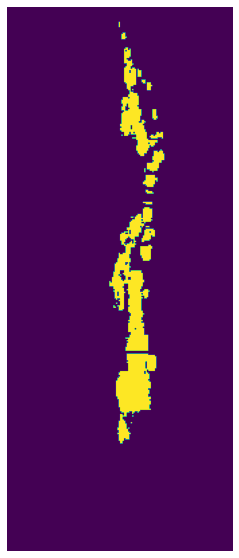

In [22]:
mip_imshow_4D(array, 90, cmap='viridis')

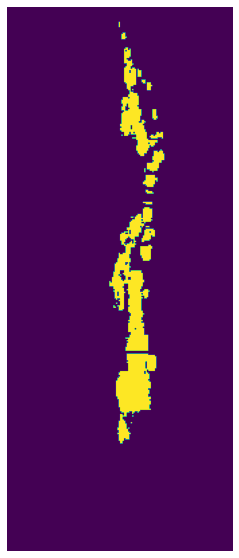

In [23]:
truth_3D = np.sum(array, axis = 3)
x,y,z = np.where(truth_3D != 0)
truth_3D[x,y,z] = 1
mip_imshow(truth_3D, 0, cmap='viridis', type='mask', vmin=None, vmax=None)

In [33]:
x,y,z = pet_img.GetSpacing()
vol_voxel = x*y*z*10**(-3)

vol_voxel * len(np.where(truth_3D != 0)[0])

738.881375456118

In [34]:
#prédictions

pred_img = sitk.ReadImage(predi)
pred_array = sitk.GetArrayFromImage(pred_img).transpose()

In [35]:
pred_array.shape

(168, 168, 405)

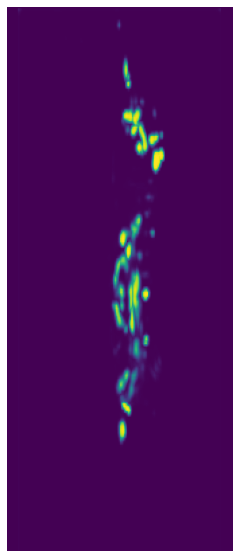

In [36]:
mip_imshow(pred_array, 0, cmap='viridis', type='mask', vmin=None, vmax=None)

In [37]:
new_mask = np.zeros((168, 168, 405))
x,y,z = np.where(pred_array >= 0.5)
new_mask[x,y,z] = 1

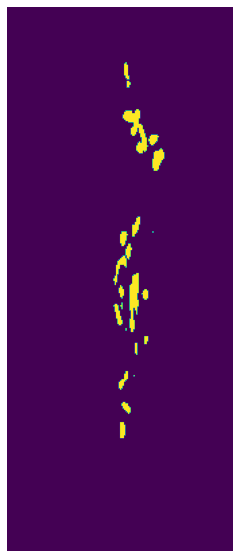

In [38]:
mip_imshow(new_mask, 0, cmap='viridis', type='mask', vmin=None, vmax=None)

In [9]:
#test watershed

model = WatershedModel(predi, pet_path, type='3d')

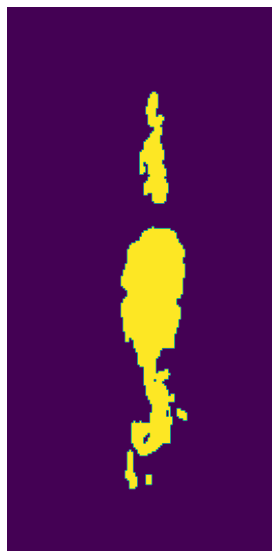

In [10]:
binary_img = model.get_binary_threshold_mask_img(0.5)
binary_mask = model.remove_small_roi(binary_img)
mip_imshow(binary_mask, 0, cmap='viridis', type='mask', vmin=None, vmax=None)

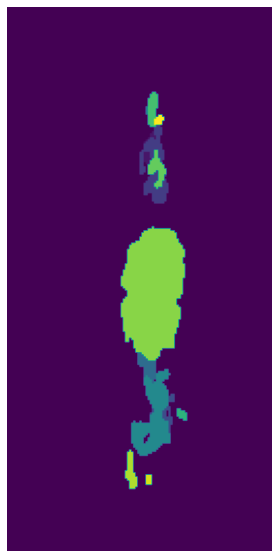

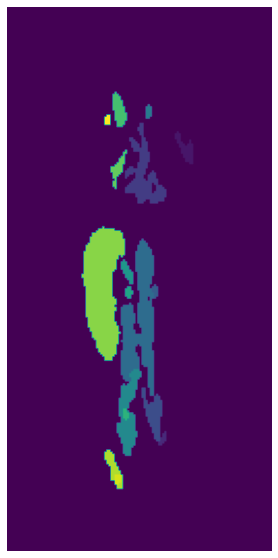

In [11]:
labelled_mask, num_label = model.get_labelled_threshold_mask_array(binary_mask)
labelled_mask.shape
mip_imshow(labelled_mask, 0, cmap='viridis', type='mask', vmin=None, vmax=None)
mip_imshow(labelled_mask, 90, cmap='viridis', type='mask', vmin=None, vmax=None)

In [12]:
ws_array, num_features = model.watershed_model(0.5)

In [13]:
num_features

49

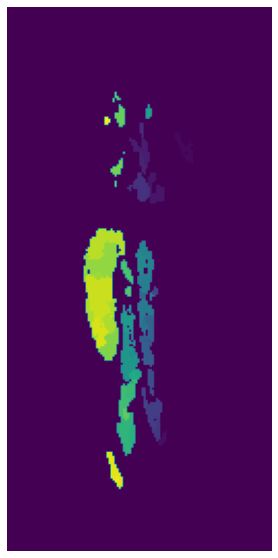

In [15]:
threshold_41 = get_threshold_matrix(ws_array, pet_array, 49, 0.41)
mip_imshow(threshold_41, 90, cmap='viridis', type='mask', vmin=None, vmax=None)

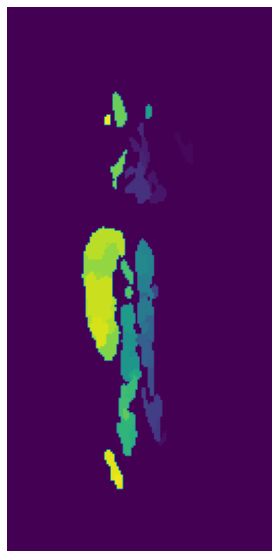

In [13]:
mip_imshow(ws_array, 90, cmap='viridis', type='mask', vmin=None, vmax=None)

In [16]:
mask_direction = model.get_mask_img_direction()
mask_spacing = model.get_mask_img_spacing()
mask_origin = model.get_mask_img_origin()

pet_direction = model.pet_direction
pet_spacing = model.pet_spacing
pet_origin = model.pet_origin

vol_voxel = pet_spacing[0]*pet_spacing[1]*pet_spacing[2]*10**(-3)

In [19]:
number_pixel = len(np.where(threshold_41 != 0)[0])
vol = number_pixel * vol_voxel

In [20]:
vol

1358.1869884081807

In [7]:
filename = os.path.join(results_directory, 'list_mip_min_dist5_6connex_V2.pdf')
create_pdf_mip(path_mip, filename) 

In [8]:
tmtv

[244.4915757223498,
 1358.1869884081805,
 804.5484282295365,
 135.10399999999998,
 77.03195591217138,
 229.06415729426953,
 92.06777683043688,
 176.35177356853092,
 428.8137746594293,
 124.07947467909253,
 289.5513731279789,
 102.56586667234878,
 169.216,
 857.2363627977029,
 380.7834622351253,
 243.712,
 155.10545563825872,
 222.78390903851778,
 756.5267649651458,
 543.9341892619268,
 161.21601921844484,
 235.71198595046997,
 197.84223558007238,
 410.0081952181175,
 424.46907559348745,
 636.672,
 306.6082296919136,
 479.424,
 335.39401525299763,
 233.02399999999997,
 285.28299288351224,
 395.41622541575634,
 873.0879479599,
 1378.339014808618,
 1256.8032429834768,
 381.3456362404162,
 787.6477562929649,
 861.1632082640273,
 1094.772706619351,
 1059.9039368247986]

In [8]:
csv_data_2[0]

['53011101371012',
 '1.2.250.1.74.20140306150000.1000040424629',
 '/media/deeplearning/Elements/AHL2011_NIFTI/1.2.250.1.74.20140306150000.1000040424629_nifti_PT.nii',
 '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/inference/1.2.250.1.74.20140306150000.1000040424629_mask_pred_float.nii',
 '/media/deeplearning/Elements/AHL2011_CSV_DATA/AHL2011-CSV/ber_gu_feb 24_2014_SK.csv',
 '268.45',
 '334.27000000000004',
 '65.82000000000005']

In [9]:
volume_total_csv = []
for row in csv_data_2 : 
    volume_total_csv.append(row[5])

In [10]:
#diff cs manual et auto
diff = []
for i in range(len(tmtv)):
    diff.append(tmtv[i] - float(volume_total_csv[i]))

In [11]:
diff

[-16.330287115112867,
 193.2265787653148,
 216.44788391586974,
 -38.46200000000002,
 -663.5980440878286,
 -1.7798676818015622,
 -404.6678878489008,
 -183.46979352892845,
 -90.53638551679148,
 -23.744465460678327,
 26.256332490399927,
 -74.40413332765121,
 -11.71399999999997,
 -106.11168121920196,
 1.2415584443278362,
 -129.40599999999995,
 -82.83733921145904,
 -61.43825109412575,
 -208.41776683521516,
 -152.84850757032746,
 -179.71197934722898,
 -417.15601413726813,
 -10.119207658680892,
 58.27121027697933,
 -121.18262627208901,
 26.1099999999999,
 -22.08028025133592,
 -56.95600000000002,
 11.256459200437973,
 -854.1460000000002,
 -31.51516983726333,
 -20.150293921839307,
 -938.4280521011351,
 199.88892213665144,
 123.85500112325826,
 -452.4880669650643,
 -17.85828481606586,
 239.86276507478624,
 340.3258074086093,
 -131.07006427764918]

In [12]:
#write csv 
nifti_directory = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/post_processing'

with open(os.path.join(nifti_directory, 'ahl_post_process_tmtv_mindist_1cm.csv'), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["PATIENT ID", "STUDY UID", "NIFTI_PET", "NIFTI_MASK", "CSV", "VOL_TOTAL", "SUM_ROI_VOLUME", "DIFF", "WS_VOL", "DIFF_WS_CSV"])
    for serie in csv_data_2: 
        index = csv_data_2.index(serie)
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], tmtv[index], diff[index]])